# 1. Introduction

Welcome to Tabular Playground Series for June 2022. This month's competition is quite interesting, where we don't need to predict output as such, but we need to predict missing values of the dataset. Thus missing values becomes our output variables.

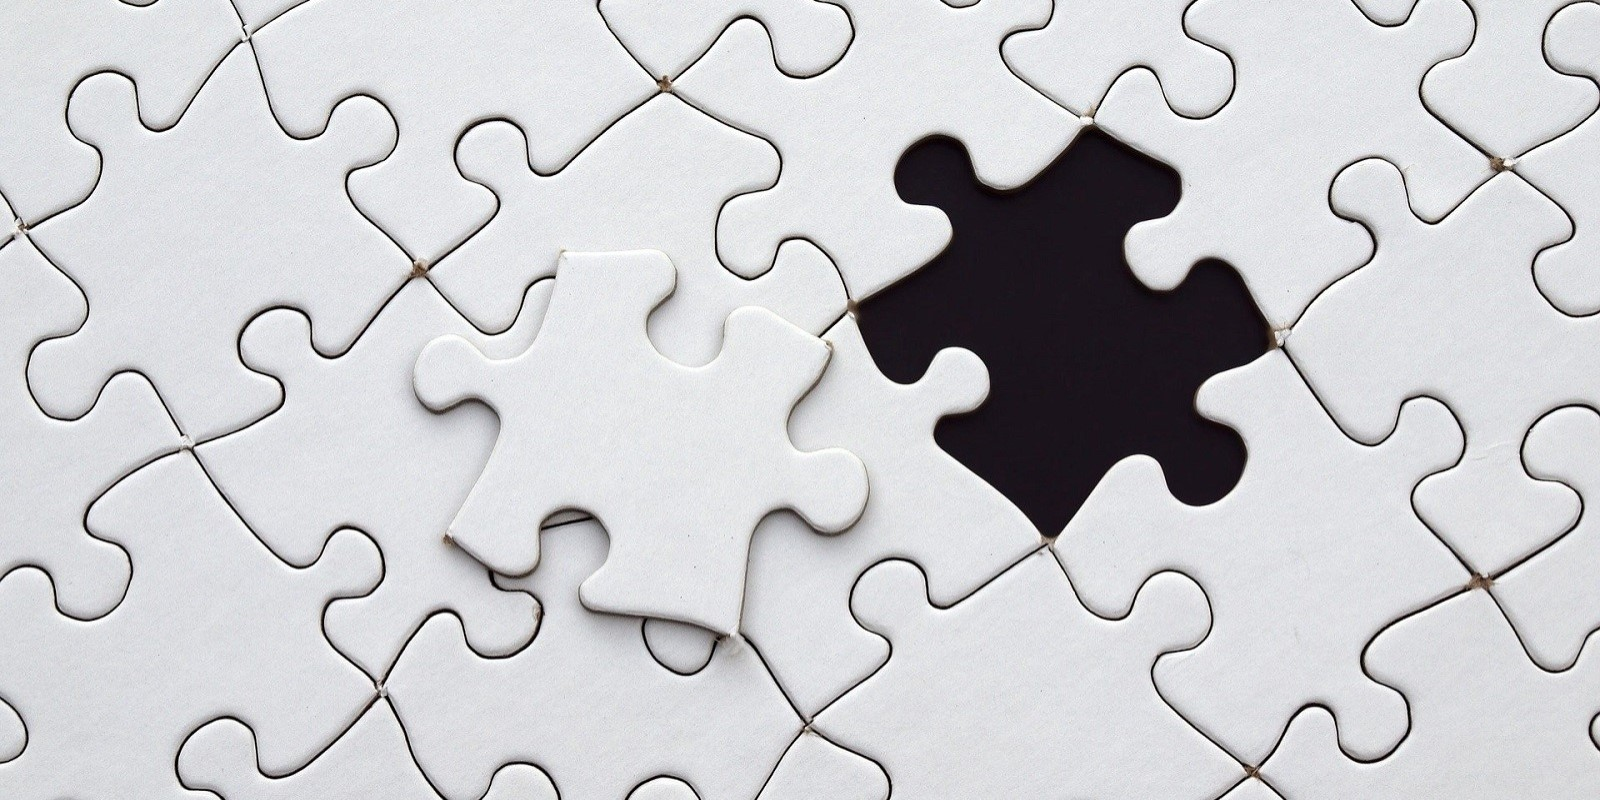

### Types of missing data:
There are three kinds of missing data:

1. **Missing Completely At Random(MCAR):** It means that the missingness is nothing to do with the person being studied. e.g. questionnaire might be lost in the post.
1. **Missing At Random(MAR):** It means that the missingness is to do with the person but can be predicted from other information about the person. It is not specifically related to the missing information. e.g. If a child does not attend an educational assessment because the child is ill, this might be predictable from other data we have about the child’s health, but it would not be related to what we would have measured had the child not been ill. 
1. **Missing Not At Random(MNAR)**: The missingness is specifically related to what is missing, e.g. a person does not attend a drug test because the person took drugs the night before. 

We do have a few techniques, which can be used for imputing missing data.

1. **Statistics methods:** We can do data impute with using Mean/Mode/Median methods.Mean can be used if data doesn't have outliers or data is symmetric. Median can be used if data have outliers or data is skewed. We can use a box plot to see if data have outliers, and a histogram to check whether is skewed or symmetric. Mode is generally used for categorical data.

1. **Python libraries:** Sklearn python library has functionality SimpleImputer which helps to impute data. Check the below link,

https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html
1. **Using Machine Learning Algorithms:** We can use a machine learning model to learn the pattern between the data and predict the missing values. This method ensures that the estimation of the missing values will not lead to data leakage.

This notebook uses machine learning algorithms to predict missing data. Machine learning model can learn the pattern between the data and predict the missing values. 

**Pros:**
* This method ensures that the estimation of the missing values will not lead to data leakage.

**Cons:**
* This method is the computationaly complex, especially if your dataset is large.

In [ ]:
import pandas as pd
import numpy as np

from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
%matplotlib inline 

In [ ]:
data_df = pd.read_csv('../input/tabular-playground-series-jun-2022/data.csv')

In [ ]:
data_df.info()

We have **55 columns with blank data**.

In [ ]:
data_df.iloc[:, 1:-1].describe().T.style.background_gradient()

In [ ]:
data_df.head()

In [ ]:
miss_col = data_df.columns[data_df.isnull().any()]
miss_col

1. **F_1, F_3, F_4** series column does have missing data, and each columns with missing data in the range of 18k.
1. **F_2** series column doesnt have any missing data.

# 2. Data Visualization

In [ ]:
features = data_df.columns
ncols = 8
for i, f in enumerate(features):
    if i % ncols == 0: 
        if i > 0: plt.show()
        plt.figure(figsize=(25, 3))
        if i == 0: plt.suptitle('Data Symmetry check', fontsize=20, y=1.02)
    plt.subplot(1, ncols, i % ncols + 1)
    plt.hist(data_df[f], bins=100) #, bins=200
    plt.xlabel(f)
plt.show()

Observations:
1. F_1 series column have normally distributed data as it follow Bell curve shape, except F_1_12, & F_1_13 column which have left skewed data.
1. F_2 series column have right skewed data. 
1. F_3 series column have normally distributed data except F_3_19, & F_3_21 column which have left skewed data.
1. F_4 selecies column have both right skewed data and normally disctributed data.


Lets understand different distribution, we have in Statistics. Data generally distributed in 3 way,

1. **Normally Distributed or Symmetrical Distribution:** A type of distribution in which values are symmetrically distributed with no skew. Most values cluster around a central region. Normally distributed data follows Bell Curve shape.Ex. Age/Height distribution of human.
> In this case, *Mean = Mode = Median*
1. **Left Skewed Or Negatively skewed:** A type of distribution in which more values are concentrated on the right side of the distribution graph while the left tail of the distribution graph is longer. Ex. The distribution of age of deaths. The distribution of the age of deaths in most populations is left-skewed. Most people live to be between 70 and 80 years old, with fewer and fewer living less than this age.
> In this case, *Mean < Median < Mode*
1. **Right Skewed or Positively Skewed:** A type of distribution in which more values are concentrated on the left side of the distribution graph while the right tail of the distribution graph is longer. Ex. The distribution of household incomes in the U.S. is right-skewed, with most households earning between  40k 𝑎𝑛𝑑 80k per year but with a long right tail of households that earn much more.
> In this case, *Mode < Median < Mean*

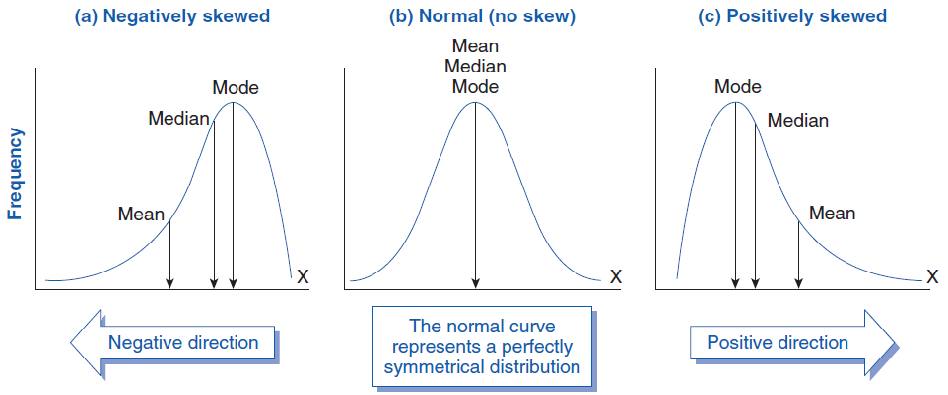

In [ ]:
plt.figure(figsize=(17,17),dpi=80)
corr=data_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, robust=True,cmap="YlGnBu", center=0, square=True, linewidths=.5)
plt.title('Correlation', fontsize=15)
plt.show()

**Covariance:**
Covariance shows how one variable is changing when other value is changing, without value. Covriance just shows direction, and not exact value. A positive value shows that both variables vary in the same direction and negative value shows that they vary in the opposite direction.

**Corelation:**
Corelations shows change in one variable leads how much proportion change in other variable. Corelation gives exact value which ranges between -1 to +1.

* -1/+1 means two variable has strong (perfect) linear corelation in negative/positive direction.
* 0 means there is no linear corelation between 2 variable, but there could be function realtionship. Check below image for more details,

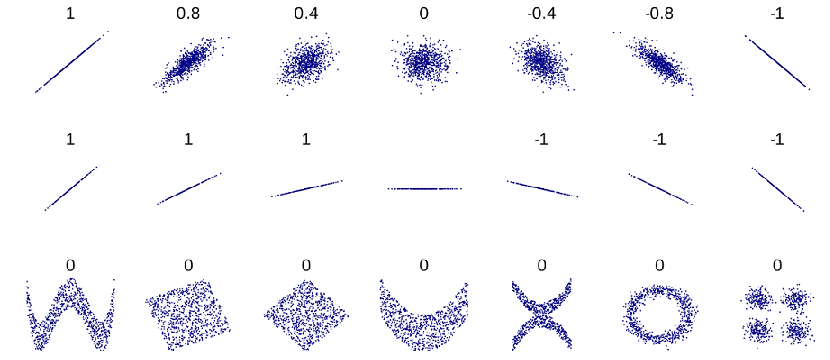

Usually in statistics there are 4 types of corelation measurement techniques,

1. **Pearson correlation:** This method evaluates the linear relationship between two continuous variables. Pearson works with raw data values of the variables.
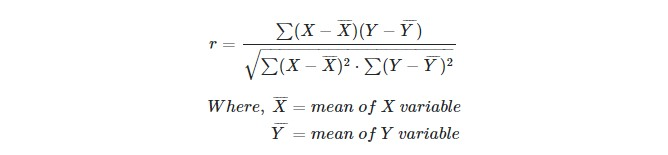
1. **Spearman correlation:** This method evaluates the monotonic relationship between two variable. This correlation coefficient is based on the ranked values for each variable rather than the raw data. Spearman works with rank-ordered variables.
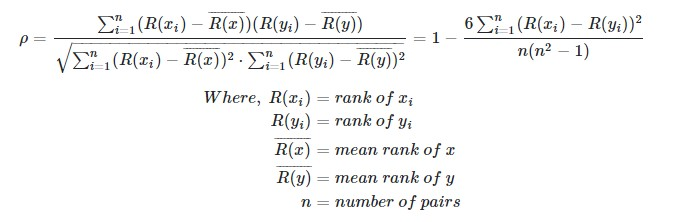
1. **Kendall rank correlation:** This method used to measure the ordinal association between two measured quantities. Kendall’s correlation coefficient uses pairs of observations and determines the strength of association based on the pattern on concordance and discordance between the pairs.
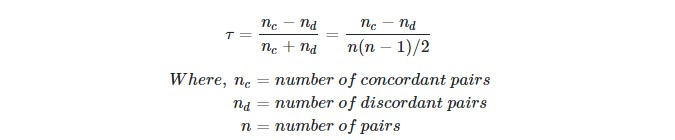
1. **Point-Biserial correlation:** A point-biserial correlation is used to measure the strength and direction of the association that exists between one continuous variable and one dichotomous variable. This is special case corelation measurement where, one of the variables is measured on a dichotomous scale. Ex.This corelation can be used to determine whether there is an association between salaries (continuous variable) - measured in US dollars, and gender (dichotomous variable, which has two categories: "males" and "females"). A **dichotomous scale** is a two-point scale that presents options that are absolutely opposite to each other. Ex. Gender(Male/Female), Employment Status (employed or unemployed)

# 3.Model Training

We can see columns have very less relation ship with each other, specifically indivdual series of columns like F_1, F_3. So for guessing missing values I am using individual series. Example. To guess F_1_0 columns data, I will use F_1 series columns.

In [ ]:
def data_impute():
    op_df = pd.DataFrame(columns=['row-col','value'])
    for col in miss_col:
        col_list=[x for x in miss_col if (col[:3] in x)]
        train = data_df.loc[(data_df[col].notnull())][col_list + ['row_id']]
        test = data_df.loc[(data_df[col].isnull())][col_list + ['row_id']]
        
        # select input variable
        X = train.drop(["row_id",col], axis=1)
        # select output variable
        y = train[col]
        
        row_id = test["row_id"].astype(str)
        X_test = test.drop(["row_id",col], axis=1).copy()
        
        # define modelboosting
        model = LGBMRegressor(boosting='dart',metric='rmse',n_estimators = 2000,learning_rate=0.1,max_depth=10)
        
        # Fit a model
        model.fit(X,y)    
        
        # Use the fitted model to predict the missing values
        predicted = model.predict(X_test)
        
        #Create a  DataFrame with the passengers ids and our prediction
        temp_df = pd.DataFrame({'row-col':row_id,'value':predicted})
        temp_df['row-col'] = temp_df['row-col'] +'-'+ col
        
        op_df = op_df.append(temp_df)
        
    return op_df

In [ ]:
submission = data_impute()

F_4 series have fluctuating RMSE, we can improve our score, if we work on them.

In [ ]:
submission.shape

In [ ]:
submission.head()

In [ ]:
submission.to_csv('submission.csv',index=False)